In [1]:
#CASO 1: Predicción de la demanda de prdouctos de una empresa, por meses
import pyodbc
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.regularizers import l2
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

plt.rcParams['figure.figsize' ] = (16, 9)
plt.style.use('fast')


In [2]:
sql_server="""
DRIVER={ODBC Driver 17 for SQL Server};
Server=US3RN4M3;
database=AdventureWorksDW2022;
Trusted_connection=yes;
"""

In [5]:
query="""
            SELECT
                CAST(f.OrderDate AS DATE) AS [sales_date],
                CAST(SUM(f.SalesAmount) AS INT) AS TotalVentas
            FROM
                FactInternetSales AS f
            WHERE 
                F.OrderDate > '2010-12-31' AND f.OrderDate < '2012-01-01'
            GROUP BY
                CAST(f.OrderDate AS DATE)
            ORDER BY
                CAST(f.OrderDate AS DATE) ASC;
"""

In [7]:
query2="""
            SELECT
                CAST(f.OrderDate AS DATE) AS [sales_date],
                CAST(SUM(f.SalesAmount) AS INT) AS TotalVentas
            FROM
                FactInternetSales AS f
            WHERE 
                F.OrderDate > '2010-12-31' AND f.OrderDate < '2014-01-01'
            GROUP BY
                CAST(f.OrderDate AS DATE)
            ORDER BY
                CAST(f.OrderDate AS DATE) ASC;
"""

In [8]:
#Configuración para el entrenamiento (hace referencia a dias)
PASOS = 31

In [9]:
#Opcion 1: Permitir que pueda ser modificada la sentencia, y mantener el try para evitar de que
# el programa se rompa
def get_sqlconnection(config_sqlServer):
    status = "inicializando...."
    try: 
        connection = pyodbc.connect(sql_server)
        status = "Conexion establecida satisfactoriamente"
    except Exception as e:
        status = "Error al establecer la conexión:"+e
    print(status)
    return connection


In [10]:
def set_index_datetime(data):
        if str(type(data) == "<class 'pandas.core.frame.DataFrame'>"):
            # data.sort_values('fecha', inplace=True)
            for column in data.columns: 
                try: 
                    pd.to_datetime(data[column])
                    data.set_index(column,inplace=True)
                    return data
                except Exception as e:  
                    pass
        else: 
            return 0

In [11]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
def create_x_y_train(data):
    values = data.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values= values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    values = reframed.values
    n_train_periods = int(len(data)) - (30+PASOS)
    print('Los periodos son: ',n_train_periods)
    train = values[:n_train_periods, :]
    test = values[n_train_periods:, :]
    x_train, y_train = train[:, :- 1], train[:, -1]
    x_val, y_val = test[:, :- 1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    return x_train, y_train, x_val, y_val, scaler, values

In [13]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Dropout(0.3)) 
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer=RMSprop(learning_rate=0.001),metrics=['mse'])
    model.summary()
    return model

In [ ]:
def entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model):
    EPOCHS = 100
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), batch_size=PASOS)
    results=model.predict(x_val)

    #Validaciones #1
    plt.scatter(range(len(y_val)),y_val,c='g', label='Valores Reales')
    plt.scatter(range(len(results)),results,c='r', label='Valores Predecidos')
    plt.xlabel('Índice')
    plt.ylabel('Valores(escalados)')
    plt.title('Grafico de dispersión entre Valores reales vs Predecidos ')
    plt.legend()
    plt.figtext(0.01,0.01,"Realizado el: "+datetime.now().strftime('%H:%M:%S %d-%m-%Y'),fontsize=10,color="gray")
    plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    plt.show()

    #Validaciones #2 
    plt.plot(history.history['loss'],label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'],label='Pérdida de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Grafico de Pérdidas de Entrenamiento y validación, según el # de Épocas')
    plt.legend()
    plt.figtext(0.01,0.01,"Realizado el: "+datetime.now().strftime('%H:%M:%S %d-%m-%Y'),fontsize=10,color="gray")
    plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    plt.show()

    #Validación #3
    plt.title('Grafico de MSE de acuerdo al # de Épocas')
    plt.plot(history.history['mse'],label='MSE de Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.figtext(0.01,0.01,"Realizado el: "+datetime.now().strftime('%H:%M:%S %d-%m-%Y'),fontsize=10,color="gray")
    plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    plt.show()

    #Preparamos la data a guardar en metadata
    datetim_e = datetime.now().strftime('%H:%M:%S %d-%m-%Y')
    optimizer_model = model.optimizer.get_config()

    #metadata
    metadata = [
            {
                "TOTAL_DE_DATOS": str(data.size),
                "EPOCH": len(history.history['loss']),
                "FECHA_ENTRENAMIENTO": datetim_e,
                "FECHA_MODIFICACION": datetim_e
            },
            optimizer_model
        ]
    print(metadata)


    ultimosDias = data[data.index[int(len(data)*0.70)]:]
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = values
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
    values = reframed.values
    x_test = values[len(values)-1:, :]
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    return model, x_test

In [15]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [16]:
def eliminar_anomalias(dtaframe):
    dataFrame_anomalias = dtaframe.copy()
    modeloIsolation = IsolationForest(contamination=0.05)
    modeloIsolation.fit(dataFrame_anomalias)
    anomalias = modeloIsolation.predict(dataFrame_anomalias)
    dtaframe['anomalias' ] = anomalias
    dataFrameSinAnomalias = dtaframe[dtaframe['anomalias' ] != -1]
    dataFrameSinAnomalias = dataFrameSinAnomalias.drop('anomalias', axis=1)
    return dataFrameSinAnomalias

In [17]:
def format_to_date(dates):
    date_format = '%Y-%m-%d'
    status = False
    try: 
        # datetime.strptime(dates['sales_date'],date_format) 
        dates['sales_date'] = pd.to_datetime(dates['sales_date'].str[:10], format='%Y-%m-%d')
        status = True
    except Exception as e: 
        status = False
        return dates

Conexion establecida satisfactoriamente


C:\Users\JoCel\AppData\Local\Temp\ipykernel_3320\2422381846.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  datos = pd.read_sql_query(query, cursor)
C:\Users\JoCel\AppData\Local\Temp\ipykernel_3320\2422381846.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  datos2 = pd.read_sql_query(query2,cursor)
c:\GitHub\pronostico\pronostico\envprediccion\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Days_format_detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1, 31)          │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 31)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            32 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,024 (4.00 KB)

 Trainable params: 1,024 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

Los periodos son:  283
(283, 1, 31) (283,) (30, 1, 31) (30,)
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6026 - mse: 0.5426 - val_loss: 0.5274 - val_mse: 0.5088
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5237 - mse: 0.4280 - val_loss: 0.5178 - val_mse: 0.4979
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5132 - mse: 0.3961 - val_loss: 0.5150 - val_mse: 0.4844
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4728 - mse: 0.3603 - val_loss: 0.5152 - val_mse: 0.4731
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4722 - mse: 0.3547 - val_loss: 0.5183 - val_mse: 0.4651
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4343 - mse: 0.2969 - val_loss: 0.5092 - val_mse: 0.4503
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4869 - mse: 0.3718 - val_loss: 0.4912 - val_mse: 0.4298
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4583 - mse: 0.3570 - val_loss: 0.4910 - val_mse: 0.4205
Ep

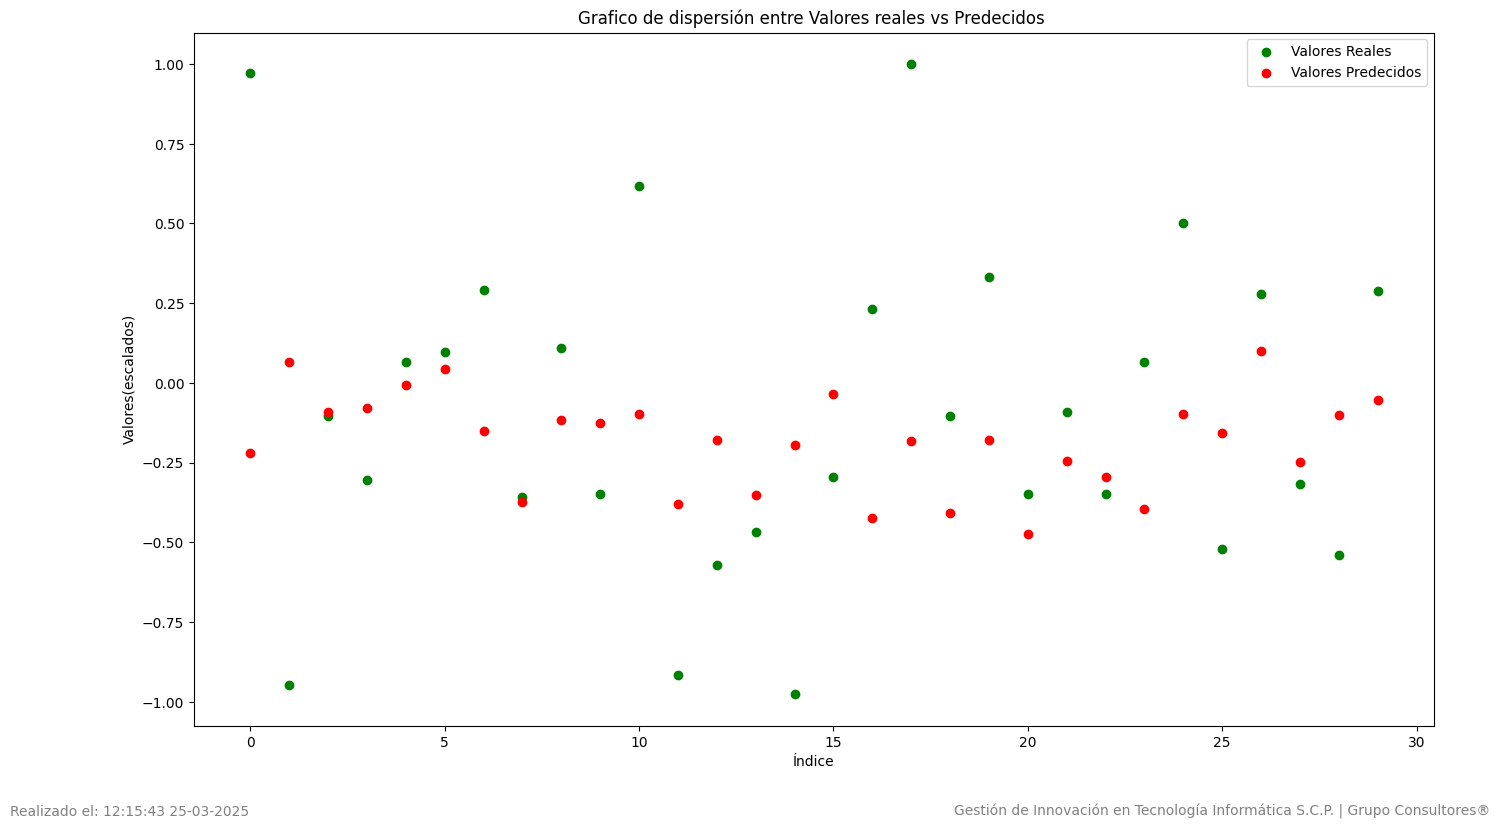

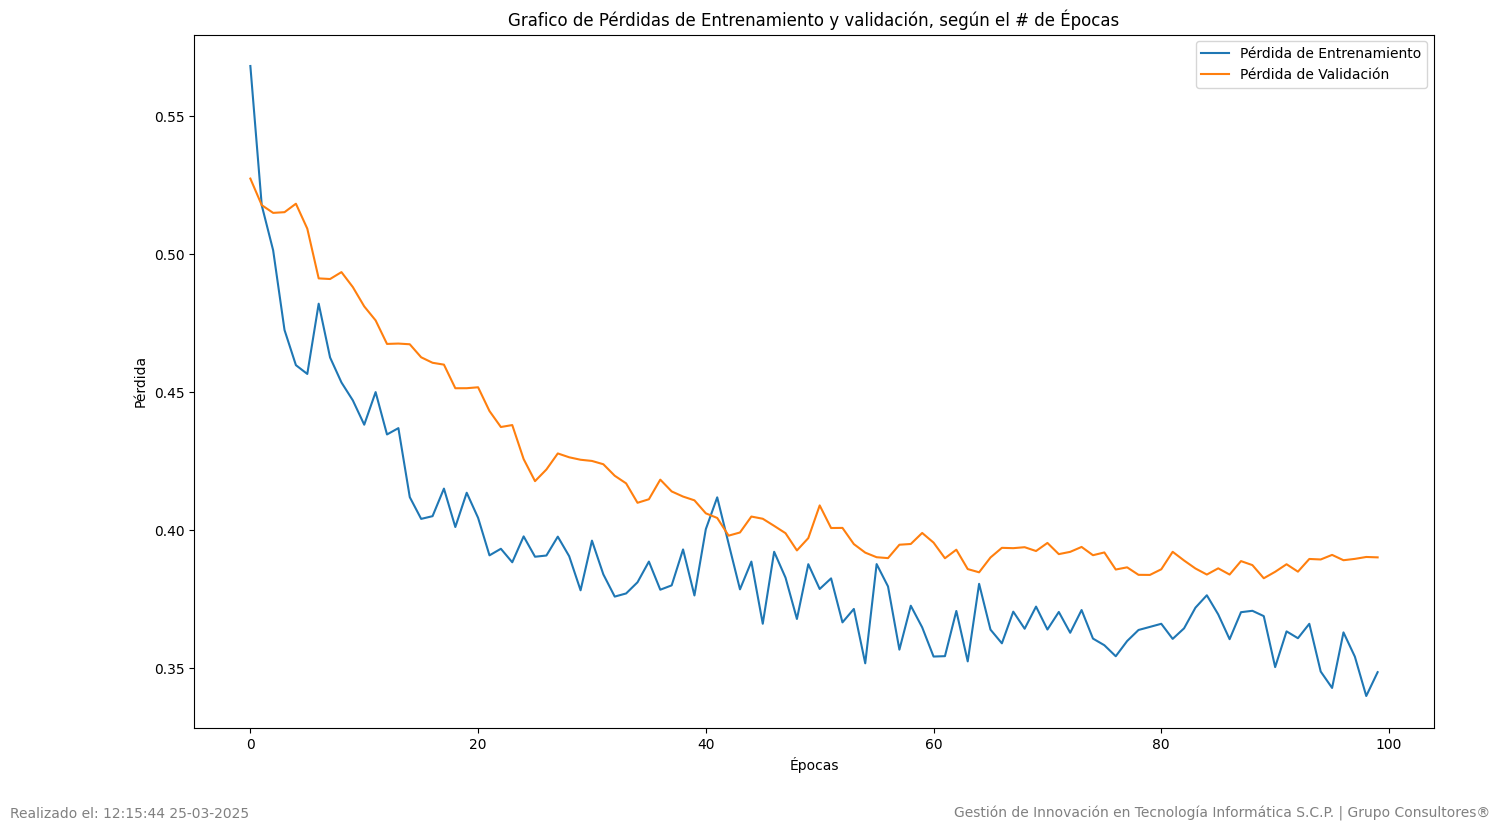

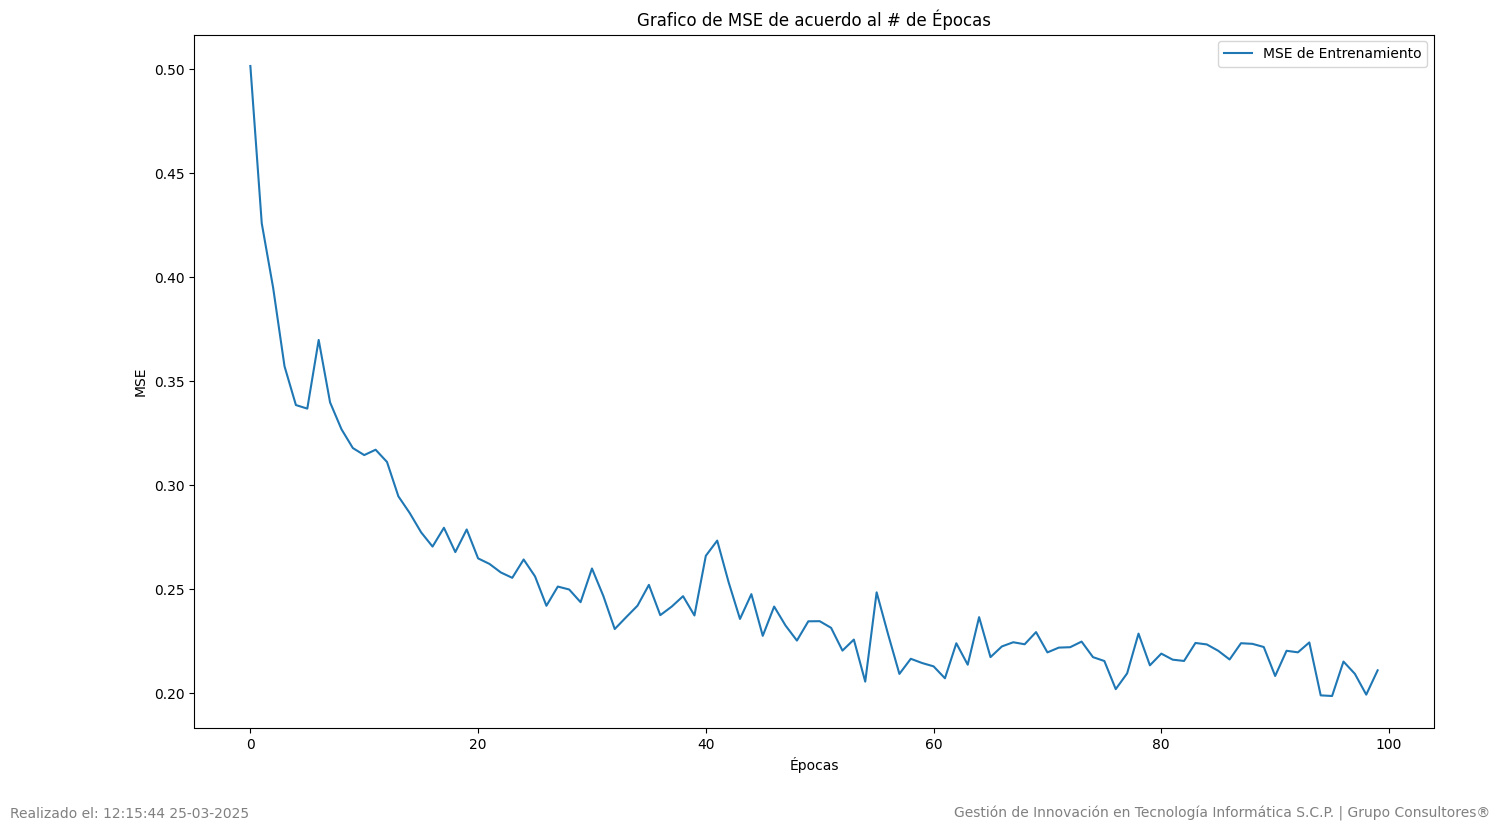

[{'TOTAL_DE_DATOS': '344', 'EPOCH': 100, 'FECHA_ENTRENAMIENTO': '12:15:44 25-03-2025', 'FECHA_MODIFICACION': '12:15:44 25-03-2025'}, {'name': 'rmsprop', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}]
[[[-0.97017705 -0.56886363  0.9716232  -0.97017705 -0.11856842
   -0.3219062   0.05488622  0.08627546  0.2812388  -0.37474394
    0.09699965 -0.36401975 -0.9387877  -0.590312   -0.48463666
   -0.99999994 -0.31118202  0.22340047  1.         -0.11856842
    0.32335222 -0.36401975 -0.10633802 -0.36401975  0.05338001
    0.49680686 -0.53898054  0.2690084  -0.3326304  -0.55771774
    0.279853  ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

C:\Users\JoCel\AppData\Local\Temp\ipykernel_3320\3877792702.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0][0][x_test.shape[2]-1]=nuevoValor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [ ]:

#El Core del sistema
with get_sqlconnection(sql_server) as cursor:
    datos = pd.read_sql_query(query, cursor)
    datos2 = pd.read_sql_query(query2,cursor)
    datos2 = set_index_datetime(datos2)
    datos = set_index_datetime(datos)
    
    #Modulo que controla si es en días o en meses
    try: 
        first_day = datetime.strptime(datos.index.min(),'%Y-%m') + relativedelta(months=1)
        last_day = datetime.strptime(datos.index.max(), '%Y-%m' ) + relativedelta(months=1)
        future_days = [last_day + relativedelta(months=i) for i in range(PASOS)]
        for i in range(len(future_days)):
            future_days[i] = str(future_days[i])[:7]
        print("Month_format_detected")
    except Exception as e: 
        #si se trata de dias
        print("Days_format_detected")
        first_day = datos.index.min() + timedelta(days=1)
        last_day = datos.index.max() + timedelta(days=1)
        future_days = [last_day + timedelta(days=i) for i in range(PASOS)]
        for i in range(len(future_days)):
            future_days[i] = str(future_days[i])[:10]
    #MD
    
    future_data = pd.DataFrame(future_days, columns=['fecha'])

    #Creamos un modelo de datos
    model = crear_modeloFF()
    data = []
    for column in datos.columns:
        data = datos.filter([column])
        data.set_index(datos.index, inplace=True)
        data = eliminar_anomalias(data)
        x_train, y_train, x_val, y_val, scaler, values = create_x_y_train(data)
        model, x_test = entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model)
        print(x_test)
        results = []
        for i in range(PASOS):
            parcial = model.predict(x_test)
            results.append(parcial[0])
            x_test = agregarNuevoValor(x_test, parcial[0])
        adimen = [x for x in results]
        inverted = scaler.inverse_transform(adimen)
        # y_pred = pd.DataFrame(inverted.astype(int))
        future_data[column]= inverted.astype(int)
    future_data = set_index_datetime(future_data)



In [19]:
print(datos)
datos

            TotalVentas
sales_date             
2011-01-01         7157
2011-01-02        15012
2011-01-03        14313
2011-01-04         7856
2011-01-05         7856
...                 ...
2011-12-27        28220
2011-12-28        18234
2011-12-29        14498
2011-12-30         3965
2011-12-31        28400

[362 rows x 1 columns]


,TotalVentas
sales_date,
2011-01-01,7157
2011-01-02,15012
2011-01-03,14313
2011-01-04,7856
2011-01-05,7856
...,...
2011-12-27,28220
2011-12-28,18234
2011-12-29,14498


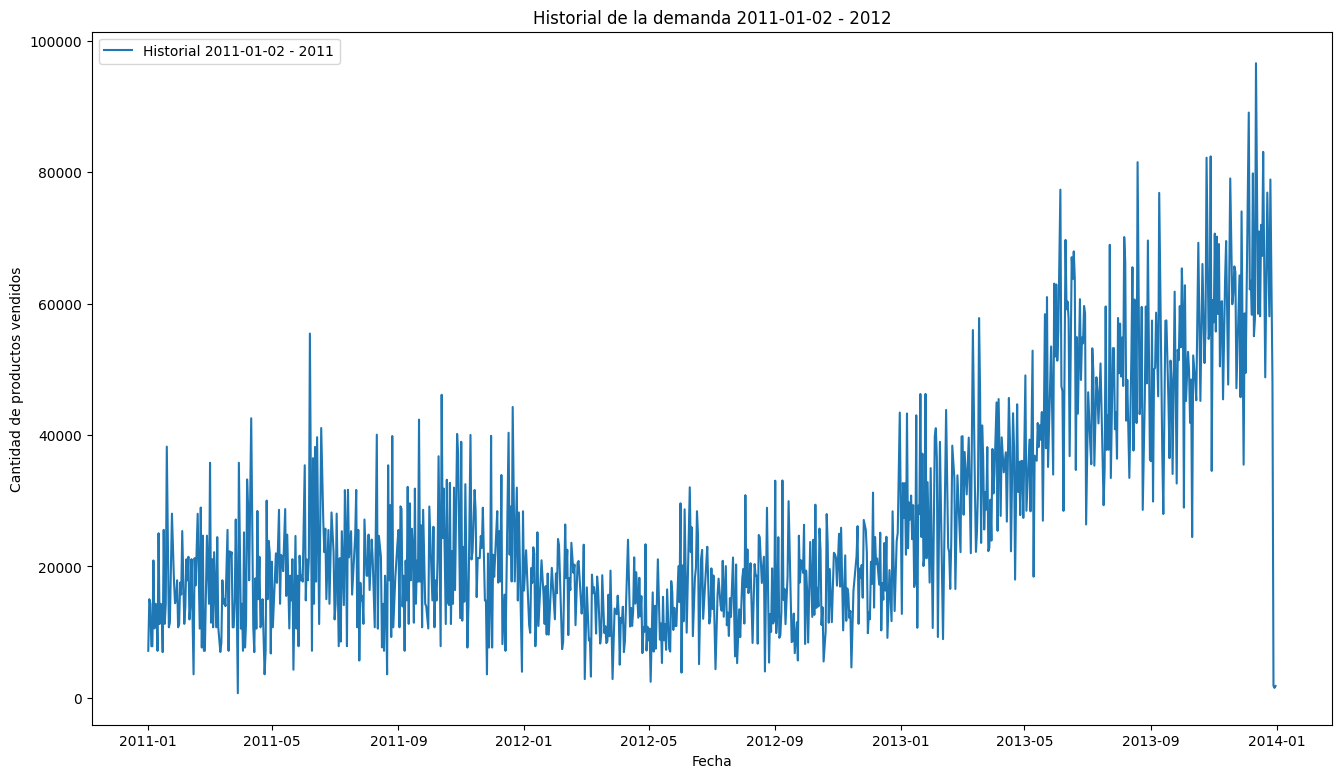

In [21]:
    datos = datos2
    datos.index = pd.to_datetime(datos2.index)
    future_data.index = pd.to_datetime(future_data.index)

    #Graficar los dataframes
    plt.plot(datos.index, datos['TotalVentas'],label='Historial {p0} - {p1}'.format(p0=str(first_day),p1=str(last_day.year-1)))
    # plt.plot(future_data.index, future_data['TotalVentas'],label='Predicción 2021 - 2022')
    # xtics = data.index.union(future_data.index)[::8]

    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de productos vendidos')
    plt.title('Historial de la demanda {p0} - {p1}'.format(p0=str(first_day),p1=str(last_day.year)))
    


    plt.legend()
    plt.show()
    # future_data

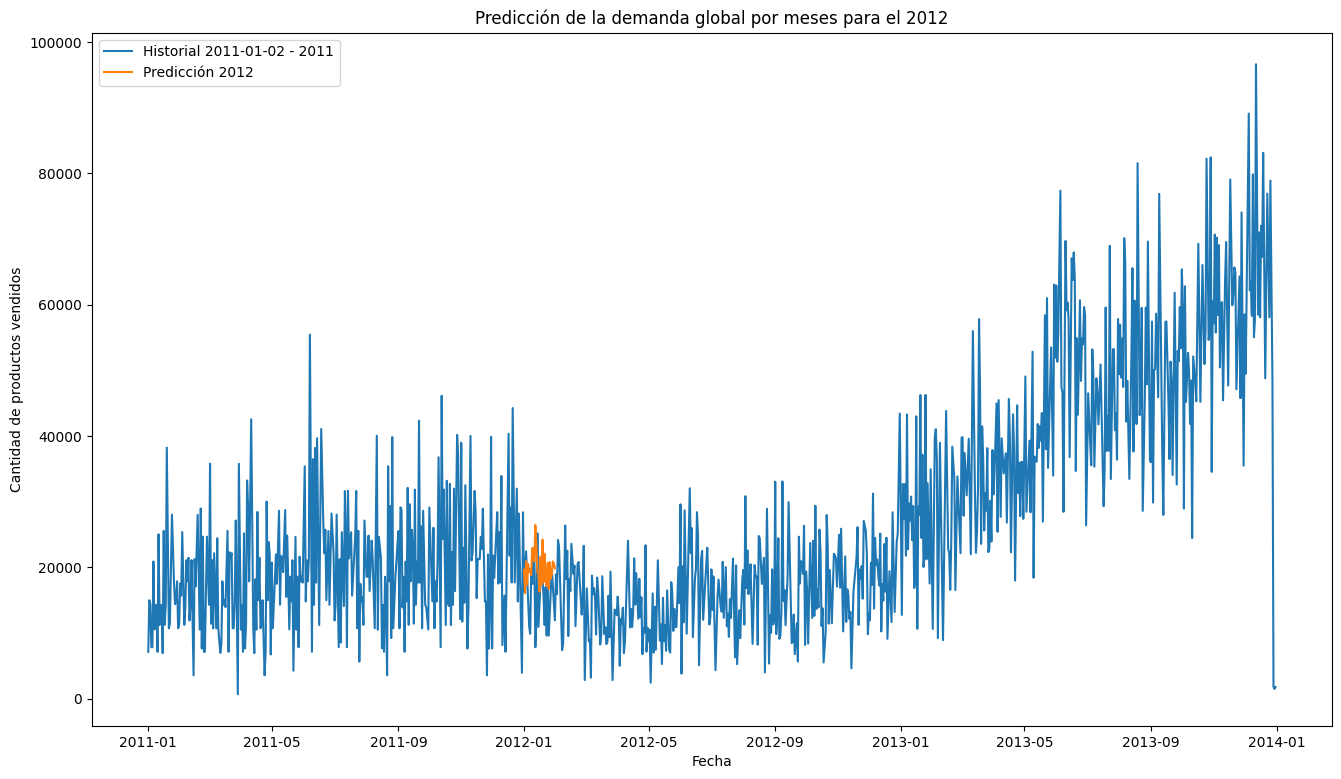

,TotalVentas
fecha,
2012-01-01,19659
2012-01-02,16089
2012-01-03,20962
2012-01-04,17380
2012-01-05,20530
2012-01-06,19249
2012-01-07,19721
2012-01-08,18849
2012-01-09,22962


In [22]:
    #Graficar los dataframes
    plt.plot(datos.index, datos['TotalVentas'],label='Historial {p0} - {p1}'.format(p0=str(first_day), p1= str(last_day.year-1)))
    plt.plot(future_data.index, future_data['TotalVentas'],label='Predicción {p0}'.format(p0=str(last_day.year)))
    # xtics = data.index.union(future_data.index)[::8]

    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de productos vendidos')
    plt.title('Predicción de la demanda global por meses para el {p0}'.format(p0=str(last_day.year)))
    


    plt.legend()
    plt.show()
    future_data